In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
import nltk
import re
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL
number of samples =  19579
shortest text len = 21 longest = 4663


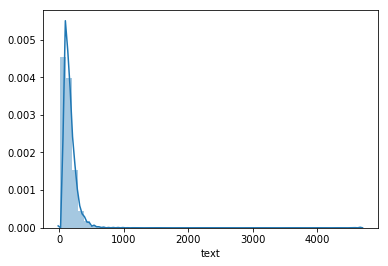

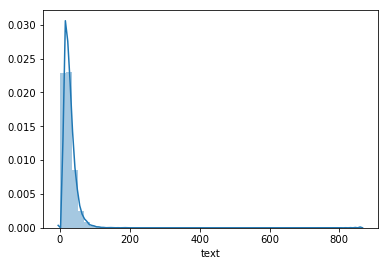

In [44]:
texts = pd.read_csv("../input/spooky-author-identification//train.csv")
print(texts.head())
print('number of samples = ',  len(texts))
print('shortest text len = {} longest = {}'.format(texts.text.str.len().min(), texts.text.str.len().max()))

sns.distplot(texts.text.str.len())
plt.figure()
sns.distplot(texts.text.str.count(' '))

We are dealing with a really small dataset here, with less than 20000 sample sentences in total. 

Next, let's do a standard train-test split with 80% of samples for training . We then check if test and train are well stratified and whether classes are relatively balanced.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(texts.text, texts.author, random_state=20171030, train_size=0.8)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

EAP    0.402477
MWS    0.307540
HPL    0.289983
Name: author, dtype: float64
EAP    0.407559
MWS    0.313330
HPL    0.279111
Name: author, dtype: float64


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 The train-test split seems reasonably well stratified, and there is no severe class imbalance.  
 
 We will start with a Naive Bayes classifier pipeline using bag-of-n-grams representation with tf-idf weighting. We sweep over four different parameters, and replace the default scorer with what we are interested in (log-loss).

In [55]:
# Helper function
def evaluate_model(model, X_test, y_test):
    predicted = model.predict(X_test)
    print('accuracy = ', sum(predicted==y_test)/len(y_test))       
    predicted1 = model.predict_proba(X_test)
    print('log-loss = ', metrics.log_loss(y_test, predicted1))
    print(metrics.classification_report(y_test, predicted))
    print(metrics.confusion_matrix(y_test, predicted))    
    
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])

parameters = {'vect__binary':(True, False),
              'vect__ngram_range': ((1,2),(1,3),(1,4)),
              'tfidf__use_idf':(True, False),
             'clf__alpha': (1e-3, 1e-2, 1e-1, 1)}

text_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, 
            scoring=metrics.make_scorer(metrics.log_loss, needs_proba=True, 
                                        greater_is_better=False)).fit(X_train, y_train)

evaluate_model(text_clf, X_test, y_test)

accuracy =  0.864657814096
log-loss =  0.343911105363
             precision    recall  f1-score   support

        EAP       0.86      0.87      0.86      1596
        HPL       0.90      0.85      0.87      1093
        MWS       0.85      0.87      0.86      1227

avg / total       0.87      0.86      0.86      3916

[[1392   60  144]
 [ 118  931   44]
 [ 118   46 1063]]


Let's take a look at the best sets of parameters.

In [50]:
cv_results = pd.DataFrame(text_clf.cv_results_)

cv_results.sort_values('mean_test_score', ascending=False)[['mean_test_score', 'mean_train_score',  
    'param_clf__alpha', 'param_vect__ngram_range', 'param_vect__binary','param_tfidf__use_idf']].head(10)

,mean_test_score,mean_train_score,param_clf__alpha,param_vect__ngram_range,param_vect__binary,param_tfidf__use_idf
18,-0.402685,-0.009838,0.01,"(1, 2)",True,False
21,-0.410424,-0.011621,0.01,"(1, 2)",False,False
19,-0.416258,-0.000819,0.01,"(1, 3)",True,False
22,-0.419246,-0.000882,0.01,"(1, 3)",False,False
20,-0.424161,-0.000219,0.01,"(1, 4)",True,False
15,-0.425715,-0.003403,0.01,"(1, 2)",False,True
23,-0.427243,-0.000224,0.01,"(1, 4)",False,False
12,-0.427889,-0.003312,0.01,"(1, 2)",True,True
9,-0.436613,-0.003605,0.001,"(1, 2)",False,False
24,-0.438665,-0.034438,0.1,"(1, 2)",True,True


Using a suitable additive smoothing parameter (pseudocount) $\alpha$ for the Naive Bayes classifier seems to be particularly important for this problem. We visualize the CV results with a couple of violin plots. The first plot clearly demonstrates that given the choice of  $\alpha = 0.01$ the mean test scores are relatively insensitive to changes in other parameters.

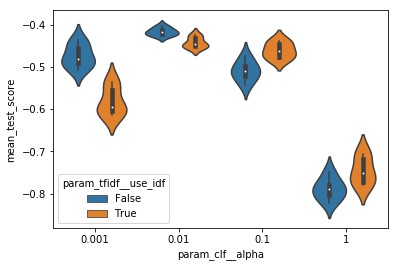

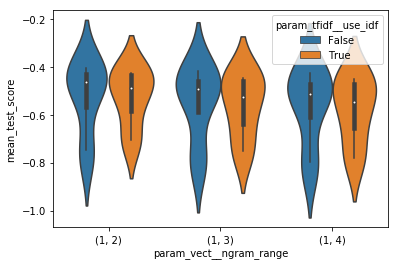

In [53]:
sns.violinplot(y="mean_test_score", x="param_clf__alpha",  hue='param_tfidf__use_idf', data=cv_results)
plt.figure()
sns.violinplot(y="mean_test_score", x="param_vect__ngram_range",  hue='param_tfidf__use_idf', data=cv_results)
plt.show()

**Combining Word and Character Features**

We next combine the features from word and **character** n-grams and see if.this combination makes any difference in the test results. To that end, we leverage the excellent FeatureUnion and Pipeline in sklearn to create a somewhat elaborate pipeline.

In [56]:
combined_features = FeatureUnion([('vecttfword', Pipeline([('vect', CountVectorizer()),
                                            ('tfidf', TfidfTransformer())])),
                                  ('vecttfchar', Pipeline([('vect', CountVectorizer(analyzer='char')),
                                            ('tfidf', TfidfTransformer())])),                                  
                                           ]) 
text_clf = Pipeline([('combined', combined_features),
                     ('clf', MultinomialNB())])

parameters = {'combined__vecttfword__vect__binary': (True, False),
              'combined__vecttfchar__vect__binary': (True, False),
              'combined__vecttfword__vect__ngram_range': ((1,1),(1,2),(1,3)),
              'combined__vecttfchar__vect__ngram_range': ((1,4),(1,5),(1,6)),
             'clf__alpha': (1e-3, 1e-2, 1e-1)}

text_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=1,
            scoring=metrics.make_scorer(metrics.log_loss, needs_proba=True, 
                                        greater_is_better=False)).fit(X_train, y_train)  
    
evaluate_model(text_clf, X_test, y_test)        

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 41.2min finished


accuracy =  0.874872318693
log-loss =  0.327359340771
             precision    recall  f1-score   support

        EAP       0.86      0.89      0.88      1596
        HPL       0.91      0.85      0.88      1093
        MWS       0.87      0.87      0.87      1227

avg / total       0.88      0.87      0.87      3916

[[1426   57  113]
 [ 112  933   48]
 [ 121   39 1067]]


Adding the character n-grams features seem to help improve classification in our test set (It turns out this also improves our LB score marginally).

In [57]:
cv_results = pd.DataFrame(text_clf.cv_results_)
cv_results.sort_values('mean_test_score', ascending=False)[['mean_test_score', 'mean_train_score',  'param_clf__alpha','param_combined__vecttfchar__vect__ngram_range', 'param_combined__vecttfword__vect__ngram_range']].head(10)

,mean_test_score,mean_train_score,param_clf__alpha,param_combined__vecttfchar__vect__ngram_range,param_combined__vecttfword__vect__ngram_range
73,-0.388369,-0.027702,0.1,"(1, 4)","(1, 2)"
91,-0.388679,-0.027477,0.1,"(1, 4)","(1, 2)"
76,-0.389285,-0.028895,0.1,"(1, 4)","(1, 2)"
94,-0.390592,-0.028868,0.1,"(1, 4)","(1, 2)"
90,-0.397491,-0.138636,0.1,"(1, 4)","(1, 1)"
93,-0.398209,-0.142087,0.1,"(1, 4)","(1, 1)"
75,-0.398610,-0.138012,0.1,"(1, 4)","(1, 1)"
72,-0.399355,-0.135587,0.1,"(1, 4)","(1, 1)"
97,-0.402512,-0.022902,0.1,"(1, 5)","(1, 2)"
96,-0.404018,-0.099956,0.1,"(1, 5)","(1, 1)"


**Linear Models**

Let's see how standard linear models perform on this data set. We only look at word-level features to get an idea how this family performs in comparison to the Naive Bayes approach.

In [58]:
lin_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='log', n_jobs=-1))])
parameters = {'vect__binary':(True,False),
              'vect__ngram_range':((1,1),(1,2),(1,3)),
              'tfidf__use_idf':(True,False),
             'clf__alpha': (1e-6, 1e-5, 1e-4, 1e-3)
             }
lin_clf = GridSearchCV(lin_clf, parameters, n_jobs=-1,
            scoring=metrics.make_scorer(metrics.log_loss, needs_proba=True, 
                                        greater_is_better=False)).fit(X_train, y_train)

evaluate_model(lin_clf, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy =  0.842696629213
log-loss =  0.453912294695
             precision    recall  f1-score   support

        EAP       0.85      0.84      0.85      1596
        HPL       0.82      0.87      0.84      1093
        MWS       0.86      0.82      0.84      1227

avg / total       0.84      0.84      0.84      3916

[[1348  126  122]
 [ 101  946   46]
 [ 141   80 1006]]


Thus logistic regression with SGD training does not outperform the  Naive Bayes on our test set.
Next we will try some boosting trees. We cap the number of features at 25000 to reduce the complexity.

In [60]:
tree_clf = Pipeline([('vect', CountVectorizer(max_features=25000, binary=True)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', GradientBoostingClassifier(n_estimators=300))]).fit(X_train, y_train)

parameters = {'vect__ngram_range': ((1,1),(1,2)),              
              'clf__learning_rate': (1e-2, 1e-1),
              'clf__subsample': (0.5, 0.8),
              'clf__max_features': ('sqrt', 0.5),
             'clf__max_leaf_nodes':(5,6,7,8,9,10)}

tree_clf = GridSearchCV(tree_clf, parameters, n_jobs=-1, verbose=1,
            scoring=metrics.make_scorer(metrics.log_loss, needs_proba=True, 
                                        greater_is_better=False)).fit(X_train, y_train)

evaluate_model(tree_clf, X_test, y_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 48.8min finished


accuracy =  0.733401430031
log-loss =  0.67533603808
             precision    recall  f1-score   support

        EAP       0.71      0.82      0.76      1596
        HPL       0.73      0.69      0.71      1093
        MWS       0.78      0.65      0.71      1227

avg / total       0.74      0.73      0.73      3916

[[1316  142  138]
 [ 254  758   81]
 [ 289  140  798]]


In [61]:
tree_clf.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_features': 0.5,
 'clf__max_leaf_nodes': 9,
 'clf__subsample': 0.5,
 'vect__ngram_range': (1, 2)}